<a href="https://colab.research.google.com/github/aneekbsws/deeplearning/blob/main/improving_nn_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial few functions

Importing libraries

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import sklearn.linear_model
import scipy.io
import math

#Defining all the known functions

In [120]:
def sigmoid(z):
  S = 1/(1+np.exp(-z))
  return S

def relu(z):
  S = np.maximum(0,z)
  return S

In [121]:
def initialization_parameters_xavier(layers_dims):
  parameters = {}
  L = len(layers_dims)
  for l in range(1,L):
    parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*math.sqrt(1/layers_dims[l-1])
    parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))  
  return parameters

In [122]:
def forward_propagation(X, parameters):
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]  
  W3 = parameters["W3"]
  b3 = parameters["b3"] 
  Z1 = np.dot(W1,X) + b1
  a1 = relu(Z1)
  Z2 = np.dot(W2,a1)+b2
  a2 = relu(Z2)
  Z3 = np.dot(W3, a2) + b3
  a3 = sigmoid(Z3)
  cache = (Z1, a1, W1, b1, Z2, a2, W2, b2, Z3, a3, W3, b3)
  return a3, cache

In [123]:
def backward_propagation(X, Y, cache):
  m = X.shape[1]
  (Z1, a1, W1, b1, Z2, a2, W2, b2, Z3, a3, W3, b3) = cache
  dz3 = 1./m*(a3-Y)
  dW3 = np.dot(dz3, a2.T)
  db3 = np.sum(dz3, axis=1, keepdims =True)

  da2 = np.dot(W3.T, dz3)
  dz2 = np.multiply(da2, np.int64(a2>0))
  dW2 = np.dot(dz2, a1.T)
  db2 = np.sum(dz2, axis=1, keepdims=True)
  
  da1 = np.dot(W2.T, dz2)
  dz1 = np.multiply(da1, np.int64(a1>0))
  dW1 = np.dot(dz1, X.T)
  db1 = np.sum(dz1, axis=1, keepdims=True)
  
  gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
  return gradients

In [124]:
def update_params(parameters, grads, lr):
  L = len(parameters)//2
  
  for i in range(L):
    # print(parameters["W"+str(i+1)].shape)
    # print(grads["dW"+str(i+1)].shape)
    parameters["W"+str(i+1)] = parameters["W"+str(i+1)] - (lr*grads["dW"+str(i+1)])
    parameters["b"+str(i+1)] = parameters["b"+str(i+1)] - (lr*grads["db"+str(i+1)])  
  return parameters

In [125]:
def compute_cost(a3, Y):
  m = Y.shape[1]
  inside_sum = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1-a3),(1-Y))
  loss = 1./m* np.nansum(inside_sum)
  return loss

In [126]:
def predict(X,Y,parameters):
  m = X.shape[1]
  p = np.zeros((1,m), dtype = np.int)
  a3, caches = forward_propagation(X, parameters)
  for i in range(0, a3.shape[1]):
    if(a3[0,i]>0.5):
      p[0,i] = 1
    else:
      p[0,i] = 0
  print("Accuracy : ",str(np.sum((p==Y)/m)))
  return p

In [127]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [128]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

#Loading 2D dataset

In [129]:
def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T
    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    return train_X, train_Y, test_X, test_Y

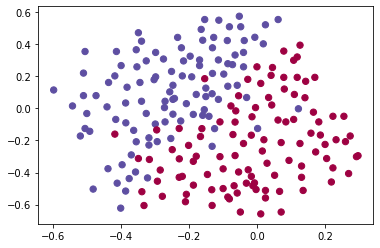

In [130]:
X_train, Y_train, X_test, Y_test = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

Parent Model Function

In [131]:
def model(X, Y, num_itr, lr, print_cost, lambd = 0, keep_prob = 1):
  m = Y.shape[1]
  layers_dims = [X.shape[0], 20,3,1]
  costs = []
  reg_type = ''
  gradients = {}
  parameters = initialization_parameters_xavier(layers_dims)
  for i in range(num_itr):
   
    if(keep_prob==1):
      a3, cache = forward_propagation(X, parameters)
    else:
      a3, cache = for_prop_with_dropout(X, parameters, keep_prob)
    if lambd == 0:
      cost = compute_cost(a3, Y)
    else:
      cost = cost_with_l2_reg(a3, Y, parameters, lambd)
    if lambd == 0 and keep_prob==1:
      gradients = backward_propagation(X,Y,cache)
    elif lambd!=0:
      gradients = back_prop_l2_reg(X,Y,cache,lambd)
    elif keep_prob<1:
      gradients = backward_prop_with_dropout(X_train, Y_train, cache, keep_prob)
    parameters = update_params(parameters, gradients, lr)
    
    if(print_cost and i % 1000==0):
      print("Cost after iteration {} : {}".format(i,cost))
      costs.append(cost)
  if(lambd != 0):
    reg_type = "L2 regularization"
  elif (keep_prob <1):
    reg_type = "Inverse Dropout"
  elif(lambd == 0 and keep_prob==1):
    reg_type = "No regularization"
  #Plot the cost
  plt.plot(costs)
  plt.xlabel("Number of iterations")
  plt.ylabel("Cost")
  plt.title("Cost improvement after using " + reg_type)
  plt.show()
  return parameters

# Non-Regularized Dataset

Cost after iteration 0 : 0.6955520993600288
Cost after iteration 1000 : 0.6931359498627058
Cost after iteration 2000 : 0.6931359498627058
Cost after iteration 3000 : 0.6931359498627058
Cost after iteration 4000 : 0.6931359498627058
Cost after iteration 5000 : 0.6931359498627058
Cost after iteration 6000 : 0.6931359498627058
Cost after iteration 7000 : 0.6931359498627058
Cost after iteration 8000 : 0.6931359498627058
Cost after iteration 9000 : 0.6931359498627058
Cost after iteration 10000 : 0.6931359498627058
Cost after iteration 11000 : 0.6931359498627058
Cost after iteration 12000 : 0.6931359498627058
Cost after iteration 13000 : 0.6931359498627058
Cost after iteration 14000 : 0.6931359498627058
Cost after iteration 15000 : 0.6931359498627058
Cost after iteration 16000 : 0.6931359498627058
Cost after iteration 17000 : 0.6931359498627058
Cost after iteration 18000 : 0.6931359498627058
Cost after iteration 19000 : 0.6931359498627058
Cost after iteration 20000 : 0.6931359498627058
Cost 

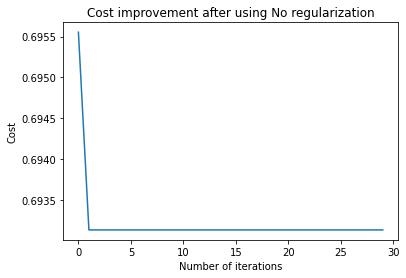

On training set : 
Accuracy :  0.5023696682464456
On test set : 
Accuracy :  0.43500000000000005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
parameters = model(X_train, Y_train, num_itr = 30000, lr = 0.3, print_cost = True, lambd = 0, keep_prob=1)
print("On training set : ")
y_pred_train = predict(X_train, Y_train, parameters)
print("On test set : ")
y_pred_test = predict(X_test, Y_test, parameters)

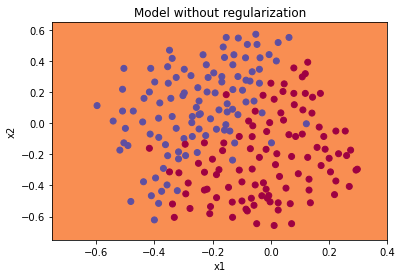

In [133]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), X_train, Y_train)

#L2 regularization

In [134]:
def cost_with_l2_reg(a3, Y, parameters, lambd):
  m = Y.shape[1]
  W1 = parameters["W1"]
  W2 = parameters["W2"]
  W3 = parameters["W3"]
  cross_entropy_cost = compute_cost(a3, Y)
  L2_cost = (lambd/(2*m))*(np.sum(np.square(W1)) +  np.sum(np.square(W2)) +  np.sum(np.square(W3)))
  net_cost = cross_entropy_cost + L2_cost
  return net_cost

In [135]:
def back_prop_l2_reg(X,Y,cache, lambd):
  (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
  m = Y.shape[1]
  dZ3 = A3 - Y
  dW3 = 1./m*np.dot(dZ3, A2.T) + (lambd/m)*W3
  db3 = 1./m*np.sum(dZ3, axis = 1, keepdims = True)
  dA2 = np.dot(W3.T, dZ3)
  dZ2 = np.multiply(dA2, np.int64(A2>0))
  dW2 = 1./m*np.dot(dZ2, A1.T) + (lambd/m)*W2
  db2 = 1./m*np.sum(dZ2, axis=1, keepdims=True)
  dA1 = np.dot(W2.T, dZ2)
  dZ1 = np.multiply(dA1, np.int64(A1>0))
  dW1 = 1./m*np.dot(dZ1, X.T) + (lambd/m)*W1
  db1 = 1./m*np.sum(dZ1, axis=1, keepdims = True)
  gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
  return gradients

Cost after iteration 0 : 0.7171736648955774
Cost after iteration 1000 : 0.2771517991022999
Cost after iteration 2000 : 0.27452024685418513
Cost after iteration 3000 : 0.27331501156279525
Cost after iteration 4000 : 0.2723078192372019
Cost after iteration 5000 : 0.27151404533800677
Cost after iteration 6000 : 0.27090830192828597
Cost after iteration 7000 : 0.27044057885178785
Cost after iteration 8000 : 0.2701053457627717
Cost after iteration 9000 : 0.2698920693805951
Cost after iteration 10000 : 0.2697376891632695
Cost after iteration 11000 : 0.2696512665414591
Cost after iteration 12000 : 0.2695652725046077
Cost after iteration 13000 : 0.2695292679836979
Cost after iteration 14000 : 0.26948088112989455
Cost after iteration 15000 : 0.2694609616529383
Cost after iteration 16000 : 0.26949018785004264
Cost after iteration 17000 : 0.269460976873019
Cost after iteration 18000 : 0.269478708955006
Cost after iteration 19000 : 0.269437283976657
Cost after iteration 20000 : 0.26947891649977457


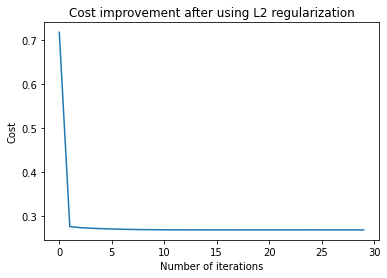

On training set : 
Accuracy :  0.9241706161137442
On test set : 
Accuracy :  0.9349999999999998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [136]:
parameters = model(X_train, Y_train,num_itr = 30000, lr = 0.3, print_cost = True, lambd = 0.75, keep_prob = 1)
print("On training set : ")
y_pred_train_l2 = predict(X_train, Y_train, parameters)
print("On test set : ")
y_pred_test_l2 = predict(X_test, Y_test, parameters)

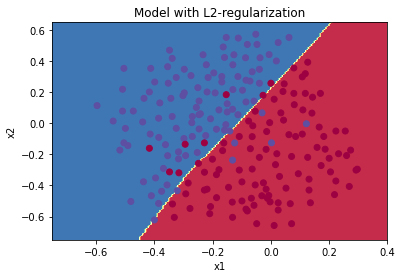

In [137]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), X_train, Y_train)

#Dropout

In [138]:
def for_prop_with_dropout(X,parameters,keep_prob):
  m = X.shape[1]
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
  Z1 = np.dot(W1,X) + b1
  A1 = relu(Z1)
  D1 = np.random.rand(A1.shape[0], A1.shape[1])
  D1 = (D1 < keep_prob).astype(int)
  A1 = D1*A1
  A1 = A1/keep_prob

  Z2 = np.dot(W2,A1) + b2
  A2 = relu(Z2)
  D2 = np.random.rand(A2.shape[0], A2.shape[1])
  D2 = (D2 < keep_prob).astype(int)
  A2 = D2*A2
  A2 = A2/keep_prob 
  
  Z3 = np.dot(W3,A2) + b3
  A3 = sigmoid(Z3)
  cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
  return A3, cache

In [139]:
def backward_prop_with_dropout(X, Y, cache, keep_prob):
  m = Y.shape[1]
  (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
  dZ3 = A3 - Y
  dW3 = 1./m*np.dot(dZ3,A2.T)
  db3 = 1./m*np.sum(dZ3, axis=1, keepdims = True)
  dA2 = np.dot(W3.T, dZ3)
  dA2 = dA2 * D2
  dA2 = dA2/keep_prob

  dZ2 = np.multiply(dA2,np.int64(A2>0))
  dW2 = 1./m*np.dot(dZ2,A1.T)
  db2 = 1./m*np.sum(dZ2, axis=1, keepdims = True)
  dA1 = np.dot(W2.T, dZ2)
  dA1 = dA1 * D1
  dA1 = dA1/keep_prob

  dZ1 = np.multiply(dA1,np.int64(A1>0))
  dW1 = 1./m*np.dot(dZ1,X.T)
  db1 = 1./m*np.sum(dZ1, axis=1, keepdims = True)
  
  gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
  return gradients

Cost after iteration 0 : 0.6932687171031203
Cost after iteration 1000 : 0.2425239767795853
Cost after iteration 2000 : 0.23447978771425074
Cost after iteration 3000 : 0.23954371771853797
Cost after iteration 4000 : 0.21691986143115782
Cost after iteration 5000 : 0.2522772648241583
Cost after iteration 6000 : 0.20338328392408725
Cost after iteration 7000 : 0.17414017541331403
Cost after iteration 8000 : 0.20040146626695185
Cost after iteration 9000 : 0.18920321282750657
Cost after iteration 10000 : 0.18137931107735553
Cost after iteration 11000 : 0.1747977407727808
Cost after iteration 12000 : 0.1797074684734543
Cost after iteration 13000 : 0.16857275087985005
Cost after iteration 14000 : 0.193575950051139
Cost after iteration 15000 : 0.16174028569350282
Cost after iteration 16000 : 0.1676708393510658


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Cost after iteration 17000 : 0.19921794085730501
Cost after iteration 18000 : 0.17811525979522508
Cost after iteration 19000 : 0.19228279845991436
Cost after iteration 20000 : 0.16274991183248924
Cost after iteration 21000 : 0.19371913532132473
Cost after iteration 22000 : 0.18345603127878932
Cost after iteration 23000 : 0.20023383545016357
Cost after iteration 24000 : 0.17471622920190452
Cost after iteration 25000 : 0.16958214455255372
Cost after iteration 26000 : 0.15166488736046008
Cost after iteration 27000 : 0.1779529808071529
Cost after iteration 28000 : 0.1574032155106255
Cost after iteration 29000 : 0.16201133724116587


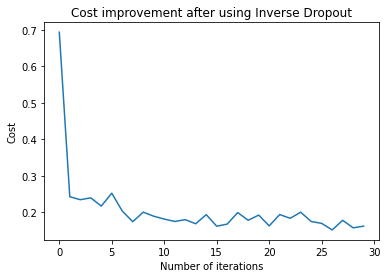

On training set : 
Accuracy :  0.9431279620853081
On test set : 
Accuracy :  0.9099999999999999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
parameters = model(X_train, Y_train,num_itr = 30000, lr = 0.3, print_cost = True, lambd = 0, keep_prob = 0.86)
print("On training set : ")
y_pred_train_l2 = predict(X_train, Y_train, parameters)
print("On test set : ")
y_pred_test_l2 = predict(X_test, Y_test, parameters)

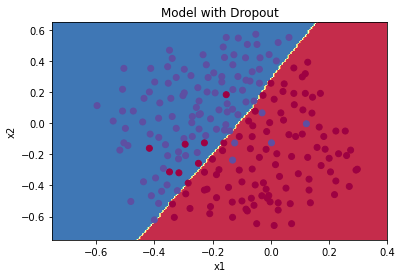

In [141]:
plt.title("Model with Dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), X_train, Y_train)